# Neuroimaging week ...: Raw MRI data and k-space transform
## Raw MRI data
In this week's lab we will focus on what the raw MRI data look like and how they are produced. The MRI signal is produced through a physical phenomenon termed nuclear magnetic resonance. The MRI signal that we get from the scanner is a complex number, i.e. it includes a magnitude and a phase component. 

In [50]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [51]:
magnitude_mat = scipy.io.loadmat('matlab_FLASH_MAGN.mat')
phase_mat = scipy.io.loadmat('matlab_FLASH_PHASE.mat')

This can be combined to its complex number form:

In [52]:
z=magnitude_mat['a']*np.exp(1j*(phase_mat['a']/4096*np.pi))
print(z)

[[ 0.        +0.j         -1.8830882 +0.6737796j  -1.6509124 +1.1289324j
  ...  3.1123064 -3.9132533j   0.66221255-1.8871869j
  -3.0701084 -3.946446j  ]
 [ 0.        +0.j         -0.10106996+0.9948793j   0.5776327 +1.914769j
  ... -0.5383231 -3.9636104j   1.9715928 -3.4803479j
  -2.7043712 -2.9472659j ]
 [ 0.        +0.j          0.99985766+0.01687299j  1.8892096 +0.6564197j
  ...  0.        +0.j         -0.57329714-0.8193475j
  -1.8855873 -3.527685j  ]
 ...
 [ 0.        +0.j         -1.0839775 -2.797319j   -1.874579  -2.3422112j
  ... -0.6707673 -2.9240503j  -2.5684419 -1.5501955j
  -0.5695205 -0.82197714j]
 [ 0.        +0.j         -3.1541462 -3.8796086j  -1.7416842 -0.98312575j
  ...  0.4356388 -2.9682014j  -0.7564051 -4.9424543j
   0.84394944-5.940349j  ]
 [ 0.        +0.j         -1.9534003 -0.42921725j -1.5499063 -1.2640374j
  ...  0.5310126 -2.9526303j  -2.509244  -6.5348063j
  -3.6849976 -8.211017j  ]]


... and the magnitude and phase images can be plotted: 

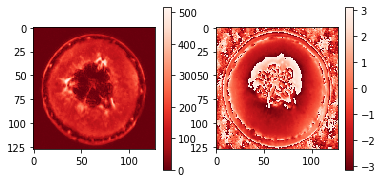

In [53]:
# plot your magnitude and phase
fig, (ax1, ax2) = plt.subplots(figsize=(6, 3), ncols=2)
magplt = ax1.imshow(np.absolute(z), cmap='Reds_r', interpolation='none')
fig.colorbar(magplt, ax=ax1)
phaseplt = ax2.imshow(np.angle(z), cmap='Reds_r', interpolation='none')
fig.colorbar(phaseplt, ax=ax2)
plt.show()

Note that contrast is easier to discern in the magnitude image of the pumpkin, so we typically just use that in (f)MRI images, with the phase image discarded. 

## K-space data

From the raw signal from a nuclear magnetic resonance experiment, there is no way to differentiate the signal from, say, different regions of the brain, i.e. there is no *spatial encoding* of the signal.

Lauterbur and Mansfield won a Nobel by discovering a way to spatially encode the signal. Essentially, spatial location is saved as a frequency signal with a magnetic gradient along the object that we want to image. In practice, this is a real-life Fourier transform from a euclidean space to a frequency space. This frequency space is what the MR scanner actually records and is called the *k-space*. 

We then *reconstruct* the spatial signal, by again applying a Fourier transform. We can see what the k-space looks like by applying a Fourier transform to our image data:

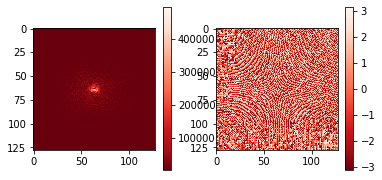

In [54]:
# k-Space transform
A=np.fft.fft2(z)
A=np.fft.fftshift(A)

# plot your magnitude and phase
fig, (ax1, ax2) = plt.subplots(figsize=(6, 3), ncols=2)
magplt = ax1.imshow(np.absolute(A), cmap='Reds_r', interpolation='none')
fig.colorbar(magplt, ax=ax1)
phaseplt = ax2.imshow(np.angle(A), cmap='Reds_r', interpolation='none')
fig.colorbar(phaseplt, ax=ax2)
plt.show()

Note that *there is no one-to-one relationship between the a point in the image space and a point in the k-space*. Instead, most of the signal of the magnitude k-space is in the center. This represents the frequencies that save the gross spatial characteristics of the image. The finer spatial detail is instead encoded in the outer side of the k-space. We can easily check what part of the k-space encodes what spatial signal, by masking the inner and outer k-space:   

In [55]:
# mask k space borders
def mask_borders(arr, num=50):
    mask = np.zeros(arr.shape, bool)
    for dim in range(arr.ndim):
        mask[tuple(slice(0, num) if idx == dim else slice(None) for idx in range(arr.ndim))] = True  
        mask[tuple(slice(-num, None) if idx == dim else slice(None) for idx in range(arr.ndim))] = True  
    return mask

outer_kspace=A*mask_borders(A)
inner_kspace=A*np.invert(mask_borders(A))

We can then reconstruct our images, by using again a Fourier tranform:

In [56]:
# reconstruct image 
imagefrom_full_kspace=np.fft.ifftshift(A)
imagefrom_full_kspace=np.fft.ifft2(imagefrom_full_kspace)
imagefrom_outer_kspace=np.fft.ifftshift(outer_kspace)
imagefrom_outer_kspace=np.fft.ifft2(imagefrom_outer_kspace)
imagefrom_inner_kspace=np.fft.ifftshift(inner_kspace)
imagefrom_inner_kspace=np.fft.ifft2(imagefrom_inner_kspace)

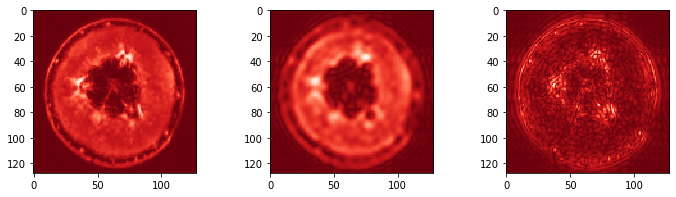

In [57]:
# plot the image reconstructed from inner and outer kspace
fig2, (ax1, ax2,ax3) = plt.subplots(figsize=(12, 3), ncols=3)
fullplt = ax1.imshow(np.absolute(imagefrom_full_kspace), cmap='Reds_r', interpolation='none')
innplt = ax2.imshow(np.absolute(imagefrom_inner_kspace), cmap='Reds_r', interpolation='none')
outplt = ax3.imshow(np.absolute(imagefrom_outer_kspace), cmap='Reds_r', interpolation='none')
plt.show()

On the left side, we see our original image. In the middle, we see the image reconstructed from the center of the k-space. Note that it looks like a lower-resolution version of the original image. On the right, we see the image reconstructed from the outer part of the k-space. This largely records the finer detail. 
To get a higher resolution image, we need to encode our signal with higher spatial frequencies. We need therefore to record a larger k-space matrix. This requires more time, but that quickly becomes prohibitive if we want to sample fMRI images quickly. 

## Undersampling and parallel imaging
To be able to record higher resolution fMRI images quickly, we frequently undersample our k-space data, by recording data from every other row (or skipping even more data). We can simulate this by making every other row zero:

In [58]:
undsersampled_kspace_R2=A*0
undsersampled_kspace_R2[::2]=A[::2]
undsersampled_kspace_R4=A*0
undsersampled_kspace_R4[::4]=A[::4]

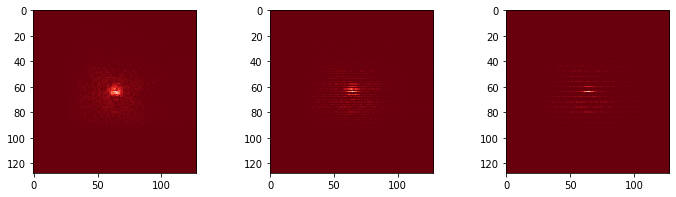

In [59]:
fig3, (ax1, ax2,ax3) = plt.subplots(figsize=(12, 3), ncols=3)
fullplt = ax1.imshow(np.absolute(A), cmap='Reds_r', interpolation='none')
r2plt = ax2.imshow(np.absolute(undsersampled_kspace_R2), cmap='Reds_r', interpolation='none')
r4plt = ax3.imshow(np.absolute(undsersampled_kspace_R4), cmap='Reds_r', interpolation='none')
plt.show()

In practice, this means that, when we reconstruct our image, the signal from several locations overlaps, creating a folding pattern:

In [60]:
imagefrom_undsersampled_kspace_R2=np.fft.ifftshift(undsersampled_kspace_R2)
imagefrom_undsersampled_kspace_R2=np.fft.ifft2(imagefrom_undsersampled_kspace_R2)
imagefrom_undsersampled_kspace_R4=np.fft.ifftshift(undsersampled_kspace_R4)
imagefrom_undsersampled_kspace_R4=np.fft.ifft2(imagefrom_undsersampled_kspace_R4)

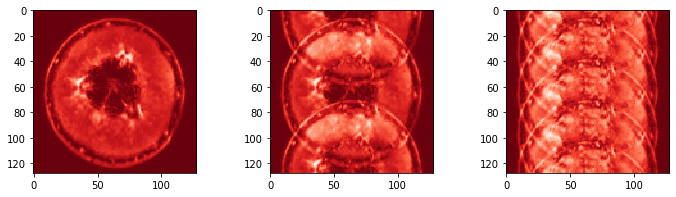

In [61]:
fig4, (ax1, ax2,ax3) = plt.subplots(figsize=(12, 3), ncols=3)
fullplt = ax1.imshow(np.absolute(z), cmap='Reds_r', interpolation='none')
r2plt = ax2.imshow(np.absolute(imagefrom_undsersampled_kspace_R2), cmap='Reds_r', interpolation='none')
r4tplt = ax3.imshow(np.absolute(imagefrom_undsersampled_kspace_R4), cmap='Reds_r', interpolation='none')
plt.show()

As you can see, the more we undersample our data, the more severe the folding becomes. We can resolve this folding pattern by using an additional (implicit) spatial encoding mechanism: in modern MRI, we record our signal with multiple small *receive coils* (parallel MRI), since this achieves higher SNR. These small coils are characterized by signal sensitivity to specific areas of the object, rather than the whole object. By modeling this coil sensitivity profile, we can resolve  the spatial origin of the signal and unfold the image.

As a guiding principle, a higher-number of smaller receive coils allow higher undersampling factors. Modern research coil arrays frequently use 32 or 64 coils. This along with improved unfolding algorithms allows undersampling factors of up to 4-6 in a single direction, vastly reducing the amount of data we need to record and allowing us to increase our spatial and temporal fMRI resolution. A big boost for undersampling approaches for fMRI was given by the Human Connectome Project. Coils and undersamling techniques for fMRI remain an active research area.